In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Comparing LSA, LDA, and NNMF

Now that you've been introduced to the logic behind these three topic extraction methods, we're going to try them out on the *Emma* corpus.  We'll be looking at interpretability, speed, and consistency across methods.  The goal is to identify common themes in *Emma* on a per-paragraph basis.  We won't be using pLSA as sklearn does not support it.

To do this, we will:

1. Parse and process the data into a tf-idf matrix.
2. Fit LSA, LDA, and NNMF models with 5 topics each.
4. Extract the words that best describe each topic.
5. Examine the topic relationships for the words 'marriage', 'love', and 'Emma.'

## Generating the tfidf matrix

In [4]:
# Processing the data.

from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer


#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10


In addition to creating the tfidf matrix, there are two convenience functions that will help keep the code tidy when comparing models.  The first provides a list of the words that are paired with each topic.  The second gives us the best words for each topic so we can compare across methods.

## Fitting the three topic extraction models

In [6]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
emma_paras_lsa = lsa.fit_transform(emma_paras_tfidf)

components_lsa = word_topic(emma_paras_tfidf, emma_paras_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)      

In [8]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

# DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will bre removd in 0.21
lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

emma_paras_lda = lda.fit_transform(emma_paras_tfidf) 

components_lda = word_topic(emma_paras_tfidf, emma_paras_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)



In [9]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
emma_paras_nmf = nmf.fit_transform(emma_paras_tfidf) 

components_nmf = word_topic(emma_paras_tfidf, emma_paras_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

We are mostly using the default settings for each method, but explicitly printing them so it is clear what is going on and how each model can be modified.  sklearn has such nice parallel structure for its various topic extraction methods that we could probably have abstracted the code even further.

# Inspecting the topics

For each topic, we list the ten most-relevant words according to each method:

In [10]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])
    

Topic 0:
               LSA            LDA             NNMF
0         oh 97.61     emma 13.25         oh 30.12
0         yes 4.79  harriet 12.72         yes 0.52
0  difference 1.59       mr 12.06       sorry 0.16
0        just 1.44     said 10.05  difference 0.15
0     harriet 1.33        oh 9.99        just 0.12
0       thank 1.33      think 9.5        papa 0.12
0       sorry 1.28       mrs 9.27        week 0.11
0       short 1.17   chapter 8.69       short 0.11
0        papa 1.15     quite 8.05    recollect 0.1
0       cried 1.02      jane 7.43      letter 0.09
Topic 1:
             LSA          LDA            NNMF
1     emma 58.27     oh 58.33         mr 7.29
1       mr 58.19   emma 19.44        mrs 4.26
1     said 50.13    mrs 15.89      elton 3.41
1      mrs 46.93   said 14.65  knightley 3.24
1     miss 37.57     mr 14.37     weston 3.15
1  harriet 35.49    yes 14.05       miss 2.99
1   weston 32.24    did 11.26  woodhouse 2.09
1    elton 27.68    miss 9.54       said 1.88
1      

A number of things are clear.  First, some topics are shared, though the order of topics varies- the 'oh' topic is first for LSA and NNMF, but second for LDA.  And second, the content of some of the topics varies considerably across methods.  This is a clear argument for using multiple methods when exploring topics.

# Sparsity

Now let's examine sparsity by looking at the distributions of loadings for the words 'marriage', 'love', 'emma', and 'oh' across the methods:

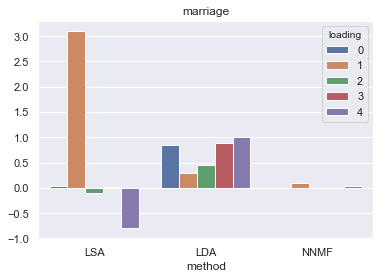

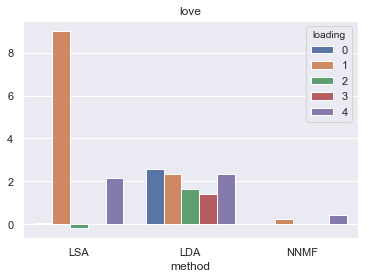

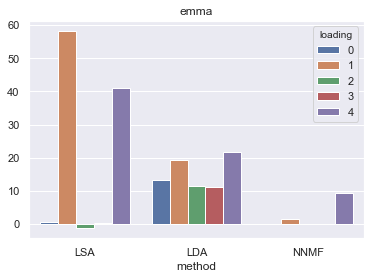

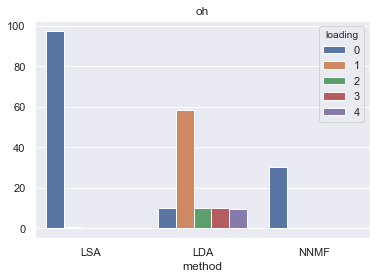

In [11]:
# The words to look at.
targetwords=['marriage','love','emma','oh']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()


LSA is the method most likely to have high loadings on more than one topic for the same word.  LDA tends to have one high loading and some lower loadings.  Loadings for NNMF are lower all around, and the most sparse, with some of the topics having loadings of zero on each word.

# Challenge: Topic extraction on new data

Take the well-known [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset and use each of the methods on it.  Your goal is to determine which method, if any, best reproduces the topics represented by the newsgroups.  Write up a report where you evaluate each method in light of the 'ground truth'- the known source of each newsgroup post.  Which works best, and why do you think this is the case?


In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

In [3]:
from pprint import pprint
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [4]:
newsgroups_train.data[2]

'well folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that (hopefully) somebody can answer:\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearence "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swing\na 180 if i got the 80Mb disk rather than the 120, but i don\'t really have\na feel for how much "better" the display is (yea, it looks great in the\nstore, but is that 

In [5]:
print(newsgroups_train.filenames.shape, newsgroups_train.target.shape)

(11314,) (11314,)


In [14]:
import re

newsgroups_train = [re.sub(r'[^a-zA-Z0-9\s]', ' ', doc) for doc in newsgroups_train.data]


In [15]:
newsgroups_train[2]

'well folks  my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985   sooo  i m in the market for a\nnew machine a bit sooner than i intended to be   \n\ni m looking into picking up a powerbook 160 or maybe 180 and have a bunch\nof questions that  hopefully  somebody can answer \n\n  does anybody know any dirt on when the next round of powerbook\nintroductions are expected   i d heard the 185c was supposed to make an\nappearence  this summer  but haven t heard anymore on it   and since i\ndon t have access to macleak  i was wondering if anybody out there had\nmore info   \n\n  has anybody heard rumors about price drops to the powerbook line like the\nones the duo s just went through recently \n\n  what s the impression of the display on the 180   i could probably swing\na 180 if i got the 80Mb disk rather than the 120  but i don t really have\na feel for how much  better  the display is  yea  it looks great in the\nstore  but is that all  wow

1. Parse and process the data into a tf-idf matrix.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Creating the tf-idf matrix.

vectorizer = TfidfVectorizer(stop_words='english')
newsgroups_train_tfidf=vectorizer.fit_transform(newsgroups_train)

# Getting the word list.
terms = vectorizer.get_feature_names()

In [19]:
# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf, solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic = tfidf.T * solution
    
    # Linking the loadings to the words in an easy-to-read way
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words,axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str)
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10

# Fitting the three topic extraction models

In [20]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd=TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
newsgroups_train_lsa = lsa.fit_transform(newsgroups_train_tfidf)

components_lsa = word_topic(newsgroups_train_tfidf, newsgroups_train_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA'] = top_words(components_lsa, n_top_words)

In [21]:
# LDA

from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

newsgroups_train_lda = lda.fit_transform(newsgroups_train_tfidf)

components_lda = word_topic(newsgroups_train_tfidf, newsgroups_train_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

In [22]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

newsgroups_train_nmf = nmf.fit_transform(newsgroups_train_tfidf)

components_nmf = word_topic(newsgroups_train_tfidf, newsgroups_train_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

## Inspecting the Topics

In [24]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])
    

Topic 0:
             LSA          LDA         NNMF
0    just 122.09      ax 7.04     don 4.45
0     like 121.2    just 5.61  people 4.44
0     don 118.05    like 5.58    just 4.26
0    know 117.29    know 5.34   think 3.84
0  people 103.96    does 5.23     like 3.8
0    think 99.55     don 5.04     know 3.3
0     does 94.54   think 4.69    good 2.85
0       use 83.8  thanks 4.64    time 2.75
0     good 83.46    good 3.85    right 2.3
0     time 81.85     new 3.83     did 2.26
Topic 1:
              LSA          LDA          NNMF
1    thanks 52.73    just 5.11  windows 5.41
1    windows 50.0    know 5.04   thanks 4.72
1      card 35.52    like 5.03    drive 3.72
1     drive 35.12  thanks 4.82     card 3.52
1      file 27.37     does 4.7     does 3.35
1       dos 27.01     don 4.53     know 3.35
1      mail 26.86   think 4.04      use 3.22
1       use 26.45     use 3.64      dos 2.84
1  software 24.04     edu 3.56     file 2.69
1        pc 23.41  people 3.54     like 2.67
Topic 2:
     

Using the words in each topic and their corresponding weights, we're able to infer the following categories:

0: 
1: graphics cards  
2: religion  
3: politics  
4: encryption  

LSA and NNMF seem to be finding similar topics, though the order of topics varies a bit and the contents of the topics varies considerably across methods. 

## Sparsity

Now let's examine sparsity by looking at the distributions of loadings for the words 'people', 'thanks', 'god', and 'pitt' across the methods:

In [36]:
components_lda.loc['god']

0     2.747569
1     2.395924
2     2.271799
3    72.750676
4     2.259024
Name: god, dtype: float64

In [ ]:
topwords.

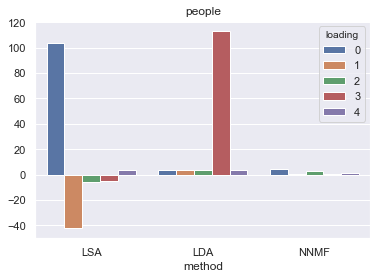

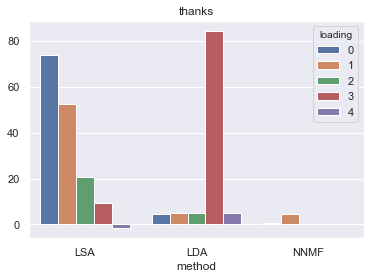

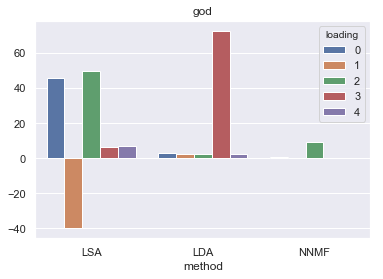

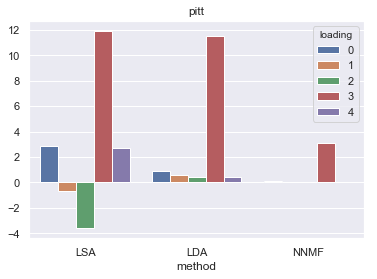

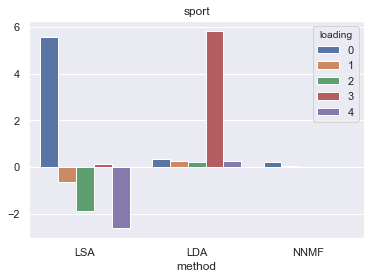

In [26]:
# The words to look at.
targetwords=['people','thanks','god','pitt', 'sport']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()


LDA method likely gives us the best way to tell topics based on the paper they are from, as with LSA we are dealing with not knowing what a negative loading refers to (sport has a negative loading in LSA with topic 1,2,and 4, but we don't know what that means. In LDA, we can see that topic 3 is highly loaded with sports).

In fact, if we do another graph with LDA looking at key insights from each of the 20 newsgroups, we may be able to tell precisely which topic deals with which using the LDA method.

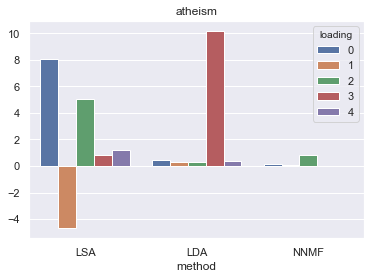

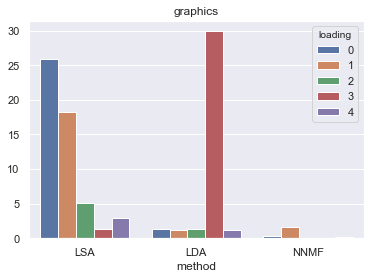

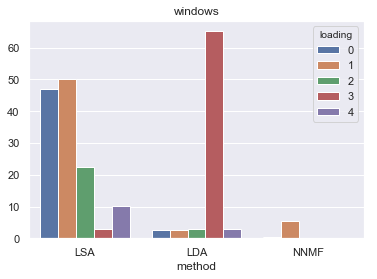

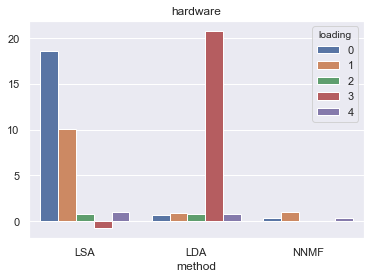

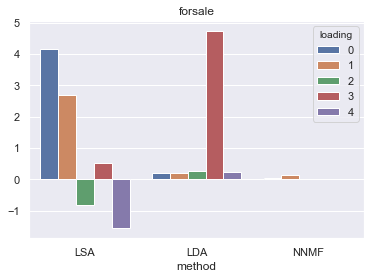

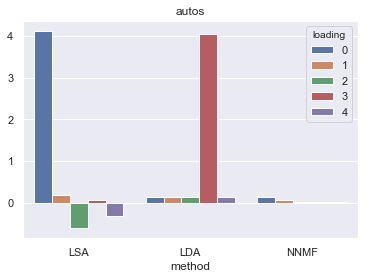

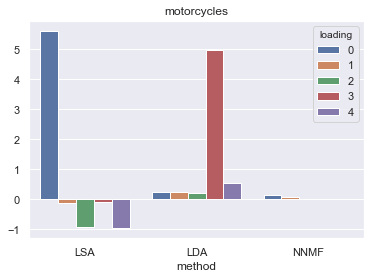

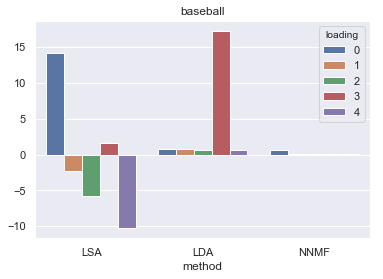

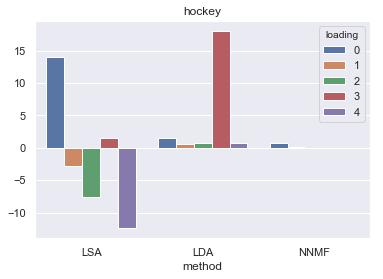

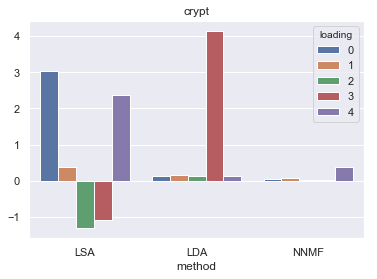

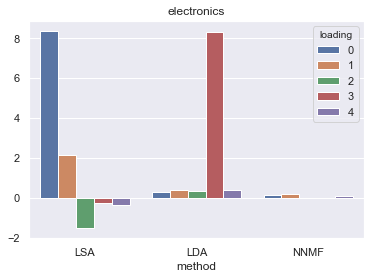

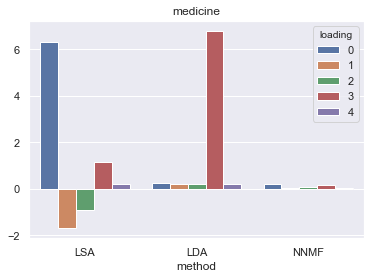

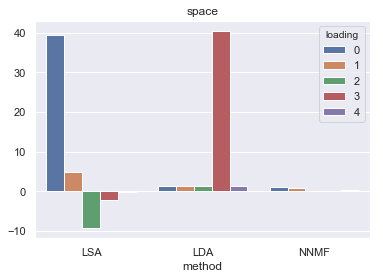

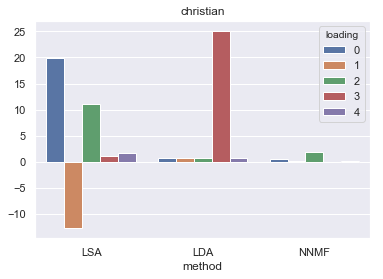

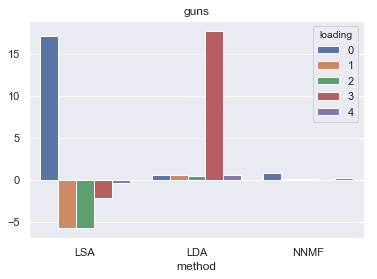

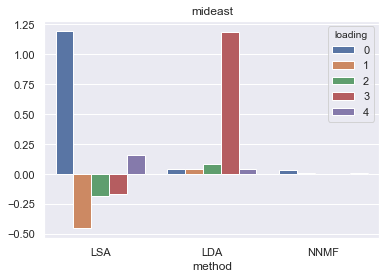

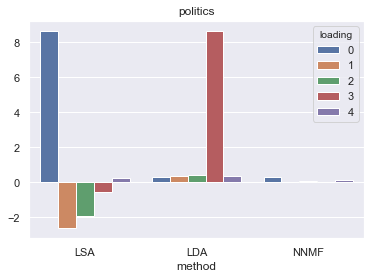

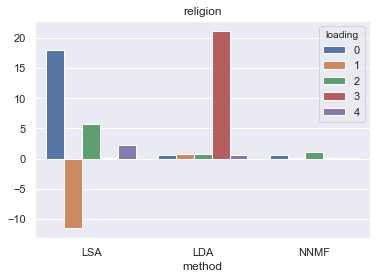

In [35]:
# The words to look at.
targetwords=['atheism','graphics','windows','hardware','forsale',
            'autos','motorcycles','baseball','hockey','crypt','electronics',
            'medicine','space','christian','guns','mideast','politics','religion']


# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x='method', y=word, hue='loading', data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()